In [1]:
import numpy as np

import matplotlib.pyplot as plt

from pydrake.all import LogVectorOutput
from pydrake.all import DiagramBuilder

from pydrake.geometry import (
    FramePoseVector,
    GeometryFrame,
    GeometryInstance,
    IllustrationProperties,
    PenetrationAsPointPair,
    PerceptionProperties,
    ProximityProperties,
    QueryObject,
    RenderLabel,
    SceneGraph,
    SourceId,
    Sphere
)

from pydrake.math import RigidTransform
from pydrake.common.value import Value
from pydrake.all import LeafSystem

from pydrake.systems.framework import kUseDefaultName
from pydrake.systems.framework import WitnessFunctionDirection
from pydrake.systems.framework import UnrestrictedUpdateEvent
from pydrake.systems.analysis import Simulator
from pydrake.systems.analysis import SimulatorConfig, ApplySimulatorConfig


In [11]:
class BouncingBall(LeafSystem):
    def __init__(self):
        super().__init__()  # Don't forget to initialize the base class.
        
        self.__restitution_coef = 1.0
        self.__viscous_friction = 0.2
        
        state_index = self.DeclareContinuousState(1,1,0)  #q=1, v=1, z=0
        #self.DeclareStateOutputPort(kUseDefaultName, state_index)
        self.DeclareStateOutputPort('y', state_index)

        self.signed_distance_witness = self.MakeWitnessFunction(
            "Signed distance", 
            WitnessFunctionDirection.kPositiveThenNonPositive,
            self.CalcSignedDistance,
            UnrestrictedUpdateEvent(self.reset)
        )
    
    def CalcSignedDistance(self, context):
        xc = context.get_continuous_state_vector()
        return float(xc.GetAtIndex(0))
    
    def get_gravitational_acceleration(self):
        return float(-9.81)
    
    def get_restitution_coef(self):
        return self.__restitution_coef
    
    def get_viscous_friction(self):
        return self.__viscous_friction
    
    #def DoCalcUnrestrictedUpdate(self, context, next_state)        
    def reset(self, context, event, next_state):
        
        next_state.get_mutable_continuous_state().get_mutable_vector().SetAtIndex(
            1, context.get_continuous_state().get_vector().GetAtIndex(1) * self.get_restitution_coef() * -1.0)     
        
    
    def DoCalcTimeDerivatives(self, context, derivatives):
        state = context.get_continuous_state_vector()
        
        # Time derivative of position (state index 0) is velocity.
        derivatives.get_mutable_vector().SetAtIndex(
            0, state.GetAtIndex(1)
        )
        
        # Time derivative of velocity (state index 1) is acceleration.
        derivatives.get_mutable_vector().SetAtIndex(
            1, self.get_gravitational_acceleration() - self.get_viscous_friction()*state.GetAtIndex(1)
        )
        
        
    def SetDefaultState(self, context, state):
        xc0 = np.array([10.0, 0.0])
        state.get_mutable_continuous_state().SetFromVector(xc0)
        
    def DoGetWitnessFunctions(self, context):
        # RETURN the self.signed_distance_witness object
        # NOT THE FUNCTION CalcSignedDistance!!
        return [self.signed_distance_witness]

In [12]:
ball_system = BouncingBall()

builder = DiagramBuilder()
builder.AddSystem(ball_system)
logger = LogVectorOutput(ball_system.GetOutputPort('y'), builder)
builder.ExportOutput(ball_system.GetOutputPort('y'))
diagram = builder.Build()

ics = [10.0, 0.0]

simulator = Simulator(diagram)

simconf = SimulatorConfig(accuracy=1e-10, max_step_size=0.01, integration_scheme='runge_kutta5')
ApplySimulatorConfig(simconf, simulator)

sim_context = simulator.get_mutable_context()

# Set the initial conditions:
sim_context.SetTime(0.0)
sim_context.SetContinuousState(ics)
sim_context.SetAccuracy(1e-10)

print("Simulating with ics: ", ics)

# Run the simulation forward.
simulator.AdvanceTo(20.0)

Simulating with ics:  [10.0, 0.0]


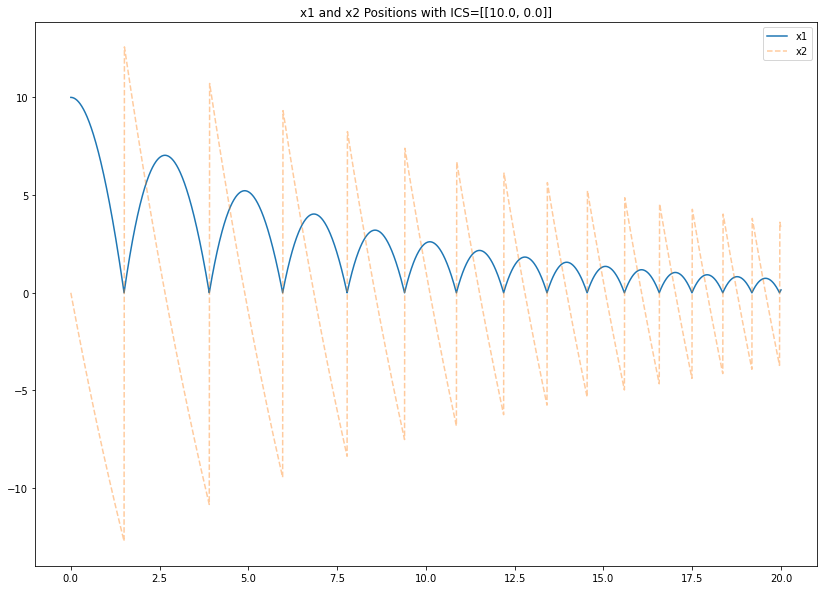

In [13]:
log = logger.FindLog(sim_context)

# Specify the figure size
plt.figure(figsize=(14, 10))

plt.title("x1 and x2 Positions with ICS=["+str(ics)+"]")
plt.plot(log.sample_times(), log.data()[0], label="x1")
plt.plot(log.sample_times(), log.data()[1], "--", alpha=0.4, label="x2")
plt.legend()
plt.show()


In [5]:
asdfadfasdf

NameError: name 'asdfadfasdf' is not defined

In [ ]:
# sim_context Setup:
sim_context = ball_system.CreateDefaultContext()         
output = ball_system.AllocateOutput()                # Returns a container that can hold the values of all of this System’s output ports. It is sized with the number of output ports and uses each output port’s allocation method to provide an object of the right type for that port.
derivatives = ball_system.AllocateTimeDerivatives()  # Returns a ContinuousState of the same size as the continuous_state allocated in CreateDefaultContext. The simulator will provide this state as the output argument to EvalTimeDerivatives.

state = sim_context.get_mutable_continuous_state_vector()
q = sim_context.get_continuous_state().get_generalized_position()
v = sim_context.get_continuous_state().get_generalized_velocity()


In [ ]:
# Setup:
context = ball_system.CreateDefaultContext()         
output = ball_system.AllocateOutput()                # Returns a container that can hold the values of all of this System’s output ports. It is sized with the number of output ports and uses each output port’s allocation method to provide an object of the right type for that port.
derivatives = ball_system.AllocateTimeDerivatives()  # Returns a ContinuousState of the same size as the continuous_state allocated in CreateDefaultContext. The simulator will provide this state as the output argument to EvalTimeDerivatives.

state = context.get_mutable_continuous_state_vector()
q = context.get_continuous_state().get_generalized_position()
v = context.get_continuous_state().get_generalized_velocity()

In [ ]:
output.get_vector_data(0)

In [ ]:
derivatives.CopyToVector()

In [ ]:
q

In [ ]:
v

# Make some tests for our system:

In [ ]:
# Computes the drop time from the initial height and the gravitational acceleration.
def CalcDropTime(g, q0):
    
    assert(g < 0.0)
    assert(q0 > 0.0)

    # The time that the ball will impact the ground is:
    # gt^2/2 + q0 = 0
    # Solve the quadratic equation at^2 + bt + c = 0 for t.
    a = g/2
    c = q0
    return np.sqrt(-c/a)

# Computes the closed form height and velocity at tf seconds for a bouncing
# ball starting from height q0, subject to gravitational acceleration g,
# and with coefficient of restitution e, assuming that the initial velocity
# is zero. Restitution coefficients of 0 and 1 are the only ones supported.
# Returns a pair of values, the first corresponding to the height at tf,
# the second corresponding to the velocity at tf.
def CalcClosedFormHeightAndVelocity(g,e,q0,tf):
    
    drop_time = CalcDropTime(g, q0)

    # Handle the cases appropriately.
    if e == 0.0:
        # TODO(edrumwri): Test these cases when we can handle the Zeno's Paradox
        # problem.
        if (tf < drop_time):
          # In a ballistic phase.
          return s[g*tf*tf/2 + q0, g*tf]
        else:
          # Ball has hit the ground.
          return [0.0, 0.0]

    if e == 1.0:
        # Get the number of phases that have passed.
        num_phases = int(np.floor(tf / drop_time))

        # Get the time within the phase.
        t = tf - num_phases*drop_time

        # Even phases mean that the ball is falling, odd phases mean that it is rising.
        if ((num_phases & 1) == 0):
            return [g*t*t/2 + q0, g*t]
        else:
            # Get the ball velocity at the time of impact.
            vf = g*drop_time
            return [g*t*t/2 - vf*t, g*t - vf]

    raise("Invalid restitution coefficient!")